In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Can we simply predict the evolution of the COVID-19 outbreak?

Related work [here](https://www.kaggle.com/sunfinger/covid-19-comparison-of-1dcnn-and-sir-model).

### Context:

SARS-COV2 have been isolated in China in decembre 2019. This is an new variant of the previous virus responsible of [SARS](https://en.wikipedia.org/wiki/Severe_acute_respiratory_syndrome) an [MERS](https://en.wikipedia.org/wiki/Middle_East_respiratory_syndrome) outbreaks. This new virus bind whith increased affinity to human cell receptors so it can infecte people more efficiently. This is why this new variant is responsible of a real pandemic outbreak.

### Objective:

The point is to predict the outcomme of the outbreak. My point is that it is not trivial, because machine learning predict future through the past. The signal is not periodic nor seasonal, It is the first time this happen. So the past could not contains informations to predict the future. However epidemiological model exists such as [the SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) mentioned in different works. But the issue is to parametrize such model based on differential equations. So what?

The important point is probably to monitor the progression of the outbreak in each country to set up health policies to avoid virus spreading. 

### Method:
Observing cumulated number of cases is not fully informative, and no comparison between countries can be done because populations are different in number. So I propose the following method.

1. Get updated data from [Johns Hopkins Github repository](https://github.com/CSSEGISandData/COVID-19)
2. Standardize countries name using [ISO 3166-1 alpha-3 nomenclature](https://www.iban.com/country-codes)
3. Reorganize data in a fonctionnal data frame and enrich data with the population number from the [world bank](https://data.worldbank.org/) with the package world_bank_data
4. Make some feature engineering to calculate:
* prevalence = number of infected people / total population
* incidence = number of new cases / total population
* lethalithy = number of deaths/ number of sick people
5. Calculate the reproduction factor with the R package EpiEstim. The [Reprocution factor](https://www.healthline.com/health/r-nought-reproduction-number) is the number of people that are contaminated by a single infected. To parametrize the SIR model we use the R0. This R0 is evaluated around 2. Remember that for measles it's about 16! So please keep your children vaccinated, it is a public-spirited behaviour.
6. Make some viz comparing the most representative countries in Asia, Europe and North America and get some insight about important source of contamination.
7. Understand a SIR model with France as an example.

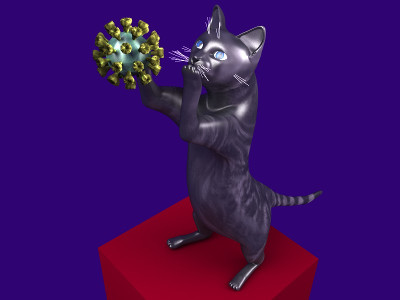

## Get Updated data

In [ ]:
import pandas as pd
import numpy as np
import os
#import world_bank_data as wb


#Load datasets
path = '../input/novel-corona-virus-2019-dataset/'
con = pd.read_csv(path+'time_series_covid_19_confirmed.csv')
rec = pd.read_csv(path+'time_series_covid_19_recovered.csv')
dea = pd.read_csv(path+'time_series_covid_19_deaths.csv')

## Standardize countries, pivot dataframes and merge them together
An custom file is used. If you think there are to many missing countries you can complete the file with the code given at the end of this notebook: 
>Just in case there are some missing country code in coutryMapping.csv


In [ ]:
#use a custom mapping file
df_map = pd.read_csv('../input/coronavirus/countryMapping.csv')

#standardize countries
scon = con.merge(df_map, how='left', on = 'Country/Region')
srec = rec.merge(df_map, how='left', on = 'Country/Region')
sdea = dea.merge(df_map, how='left', on = 'Country/Region')

#check missing country code
scon.loc[scon['Country Code'].isna(), 'Country/Region'].unique()

In [ ]:
#Stack and merge dataframes
def stack_df(df, field):
    tmp = df.iloc[:,4:]
    tmp = tmp.groupby('Country Code').sum()
    tmp =tmp.stack().reset_index()
    tmp.columns=['country', 'dates', field]
    return tmp

scon = stack_df(scon, 'confirmed')
srec = stack_df(srec, 'recovered')
sdea = stack_df(sdea, 'deaths')
df = scon.merge(srec, on=['country', 'dates']).merge(sdea, on=['country', 'dates'])
df.head()

## Feature engineering

In [ ]:
df['dates'] = pd.to_datetime(df.dates)
df['actives'] = df.apply(lambda x: x.confirmed - x.deaths - x.recovered, axis = 1)
df['lethality'] = df.apply(lambda x: 100*x.deaths / x.confirmed if x.confirmed > 0 else 0.0, axis = 1)

'''Convert cumulative Confirmed to new cases'''
newCases=[]
for cc in df.country.unique():
    sel =  df.loc[df.country==cc].sort_values('dates')
    cumul = sel.confirmed.values
    dates = sel.dates.values
    newCases.extend([(cc, dates[0], cumul[0])] + [(cc, dates[ix+1], i- cumul[ix]) for ix,i in enumerate(cumul[1:])])
newCases = pd.DataFrame(newCases, columns = ['country','dates','new_cases'])
df = df.merge(newCases, on=['country','dates'])
df.head()

'''Calculate prevalence & incidence from world bank population data'''
#Deprecated because can't !pip install world_bank_data
# wb_pop = pd.DataFrame(wb.get_series('SP.POP.TOTL', date='2018', id_or_value='id',simplify_index=True)).reset_index()
# wb_pop = wb_pop.rename(columns={'Country':'Country Code', 'SP.POP.TOTL':'population'})
#Replaced by
dfp = pd.read_csv('../input/coronavirus/world.csv')
wb_pop=  dfp.loc[dfp['Series Code'] == 'SP.POP.TOTL',['Country Code','2018 [YR2018]']]
wb_pop['2018 [YR2018]'] = wb_pop['2018 [YR2018]'].apply(lambda x: eval(x) if x !='..' else np.nan)
wb_pop = wb_pop.rename(columns={'2018 [YR2018]': 'population'})

df = df.merge(wb_pop, left_on = 'country', right_on='Country Code')
del df['Country Code']
df['prevalence'] = df.apply(lambda x: round(10000*x.confirmed/x.population,5), axis = 1)
df['incidence'] = df.apply(lambda x: round(10000*x.new_cases/x.population,5), axis = 1)
df.dropna(inplace=True)
df.head()

## Evaluation of Reproduction Factor with the R package EpiEstim
 This method needs a parametrization of serial interval. I used values from a [prepublished paper](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article)

In [ ]:
'''Apply R script to calculate Reproduction Factor from Epiestim package'''
#df.to_csv('covid19_epi.csv', index=False)
#if os.system('Rscript get_R.R')!=0:
#    print('Error in R script: get_R')

"""ReproductionFactor.csv is obtained from the R script get_R.R provided here:
library(EpiEstim)

covid19 <- read.csv("~/Documents/deep_learning/coronavirus/covid19_epi.csv")
covid19$dates<-as.Date(covid19$dates)
firstpass<-TRUE
for (i in unique(covid19$country))
{
  sel <- subset(covid19, country==i)

  #reproduction number
  df=subset(sel, select=c(dates, new_cases))
  names(df)[2] <- "I"
  df$I<-replace(df$I, df$I<0, 0)
  res_parametric_si <- estimate_R(df, method="parametric_si", config = make_config(list(mean_si = 3.96, std_si = 4.75)))
  si_param<-res_parametric_si$SI.Moments
  si_dist<-res_parametric_si$si_distr
  R<-subset(res_parametric_si$R, select=c(`Mean(R)`, `Quantile.0.05(R)`, `Median(R)`, `Quantile.0.95(R)`))
  R$dates<-res_parametric_si$dates[(2:(length(res_parametric_si$dates)-6))]
  R$country<-i
  if(firstpass)
  {
    concat<-R
    firstpass<-FALSE
  }
  else
    concat<-rbind(concat,R)#c(concat,R)
}

path<-"~/Documents/deep_learning/coronavirus/"
write.csv(concat,paste(path,"ReproductionFactor.csv")) 
"""

dfr = pd.read_csv('../input/coronavirus/ReproductionFactor.csv')
del dfr['Unnamed: 0']
dfr.columns=['mean', 'Q5', 'med', 'Q95', 'dates','country']
dfr['dates'] = pd.to_datetime(dfr.dates)

## VIZ

Utilities functions are defined below. The main plotting library used is Plotly, because it allow interactivity on graph for a better reading.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plotCountries(feature, df, title, country = None):
    weeks = mdates.WeekdayLocator()
    dayMonth_fmt = mdates.DateFormatter('%m-%d')
    fig, ax = plt.subplots(figsize = (12,6))
    if not country is None:
        tmp = df.loc[df.country== country]
        g=sns.lineplot(x="dates", y="mean", data=tmp)
        g.fill_between(x="dates", y1="Q5", y2="Q95", data=tmp, alpha=0.2)
    else:
        g = sns.lineplot(x="dates", y=feature, hue="country",  data=df)
    g.set_title(title)  
    g.xaxis.set_major_locator(weeks)
    g.xaxis.set_major_formatter(dayMonth_fmt)
    plt.xticks(rotation=30) 
    

def plotRegion(countries):
    #subset of selected countries
    sel = df.loc[df.country.isin(countries)]
    rsel = dfr.loc[dfr.country.isin(countries)]
    #Common X axis
    dates = [np.datetime_as_string( i, unit='D') for i in sel.dates.values]
    #create multiple subplots on one layout
    fig = make_subplots(
        rows=3, cols=2,
        specs=[[{}, {}], [{}, {}], [{"colspan": 2}, None]],
        subplot_titles=("Number of infectious cases", "Number of cases per 10 000 capita", "Number of new cases per 10 000 capita", "Lethalithy in %","Reproduction Factor"))
    #plot features from sel
    for idx, feature in enumerate(['actives','prevalence','incidence','lethality']):
        for i in sel.country.unique():
            tmp = sel.loc[sel.country == i]
            fig.add_trace(go.Scatter(x=dates, y=tmp[feature].values, mode='lines', name=i, legendgroup=i, showlegend= not idx), row=idx//2+1, col =idx%2+1)
    #plot R factor from rsel
    for i in sel.country.unique():
            tmp = rsel.loc[rsel.country == i]
            fig.add_trace(go.Scatter(x=dates, y=tmp['mean'].values, mode='lines', name=i, legendgroup=i, showlegend= False), row=3, col =1)        
    return fig.update_layout(height=800, title_text="Descriptive epidemiology in Europe"), sel, rsel #height=900, width=1200, 

def getLastR(df):
    return df.loc[df.groupby('country').dates.idxmax()].sort_values('mean',ascending=False)

def getCorrLethality(df, countries):
    return pd.DataFrame([(i, df.loc[(df.country == i)&(df.prevalence>0.2)][['lethality','prevalence']].corr().values[0][1]) for i in countries],\
             columns = ['country', 'corr']).sort_values('corr', ascending =False).dropna()

def choropleth(df, scope, field, uppad=0):
    #get min max of the feature for color scaling
    scales = df[field].describe()
    #define map for Reproduction Factor
    fig = px.choropleth(df, locations='country', color=field,
                               locationmode='ISO-3',
                               color_continuous_scale="Viridis",
                               range_color=(scales['min'], scales['max']-uppad),
                               scope=scope,
                               labels={field:'Reproduction Factor'}
                               #,width = 1200, height = 600
                              )
    return fig.update_layout()#autosize=False, width=1200, height=900,margin={"r":0,"t":0,"l":0,"b":0}


## Situation in Europe

In [ ]:
countries=['FRA', 'ITA', 'ESP', 'DEU', 'SWE','SWZ', 'GBR', 'BEL','AUT','NLD']
fig, sel, rsel = plotRegion(countries)
fig.show()

The first two plots up shows the start of the outbeak in each country, when the number of cases start to grow exponentialy. For example one can see that there are 10 days difference between Italy and other countries, but UK that is 16 days late. We can observe higtest prevalences for Italy, Spain, Germany and Austria.

The plot about incidence tell us that Italian and Spainish undergoe an heavy pression for pepole admission. 

The lethality plot show the surprise effect: a new disease is coming and we are not prepared. This is obious for France and Italy. Morever, and that is disturbing, lethality increase with time, but prevalence also increase with time and those 2 values may be correlated (yes they are Cf the next cell). There are 2 explications:
* Virus become more lethal when circulating into population
* Hospital are overwhemed and cares are not sufficient to save more people.

The last plot is very interesting.It show the evolution of the reproduction factor. When decreasing to 1 there are as many new cases as recovered or dead people. We have reach the climax of the outbreak and the situation wil improve. When R=0 the outbreak is over. Morever this graph allow to pick the R0 value for parametrization of the SIR model. Finnaly it show significant events preceeding the spread od the disease. For example in Italy around the 14 Februry, one infected transmitted the disease to 50 people! The 15 february is the national day of carnaval in Italy. The Venice session have been canceled but not the minor carnavals in every town are village. 


In [ ]:
getCorrLethality(sel, countries)

### A detailled plot of the R factor with a confidence interval of 95%.

At the begging the confidence interval is large and become thiner while more learning data are availlable. Notice that the estimation of R is 6 days late, because a slidding window is used for the calculus. R0 should be 2 for France.

In [ ]:
plotCountries('mean',rsel,'Reproduction factor in France','FRA')

## geographical plot of Reproduction factor

Swizerland have a current R factor = 5, they are at the beginning of the story. It is removed from plot to convenience because one could not have seen subtile differences between other countries. The more the country is dark, the more is close to the stabilization... Yes colors should have been inverted for a better representation... Anyway.

In [ ]:
tmp = getLastR(rsel)
choropleth(tmp, 'europe', 'mean',4)

## Situation in Asia

In [ ]:
countries=['CHN', 'KOR', 'JPN','MYS','THA','IRN','IND','AFG','IRK']
fig, sel, rsel = plotRegion(countries)
fig.show()

The lethality peak for Iran the 19 February is connected to the very day when COVID-19 have been officially declared by iranian authorities whiel asking for a softening of embargo. Trump refused and is partly responsible for the many deaths in Iran. The correlation beetween lethality and prevalence is the higher for Iran. May be times will come when USA stop to impose his will and discover mercy.
Outbreak is only beginning in India, Hope they are prepared.

In [ ]:
tmp = getLastR(rsel)
choropleth(tmp, 'asia', 'mean')

In [ ]:
getCorrLethality(sel, countries)

In [ ]:
countries=['USA','CAN','MEX']
fig,sel, rsel = plotRegion(countries)
fig.show()

## What happened in USA around the 17 february?
I'm not sûre is it the president's day?

The correaltion between prevalence and lethality is negative because it is the very beginning (surprise effect)

A reproduction factor>2 in US the 15 March: **Stay at home!!** Work in remote whenever it is possible and think twice before to tell yourself that you have something important to do outside. Think about the wonderfull vetor you are for the virus spreading.

In [ ]:
getCorrLethality(sel, countries)

In [ ]:
tmp = getLastR(rsel)
choropleth(tmp, 'north america', 'mean')

## SIR model

For SIR parametrization we need beta and gamma:

$\gamma$ = 1/number of days before recovering or die from the disease (probability to recover or die)

$\beta$ is the probabilty to become infectious for a succeptible person with :

R0 = $\beta$ / $\gamma$ <=>$\beta$ = R0.$\gamma$

For the example of France we can choose 2<= R0 <=4 and $\gamma$ = 1/14
The following model is expressed in probabilties and proportion:
* S0 = Proportion of the population that is succeptible / exposed
* I0 = Proportion of infectious people at the begining of the out break

So if we want to standardize observed real data we need to divide by the total population. But are the confirmed active cases speaking truth. Absolutly not, A large proportion of people will be infected but never tested thus not confirmed. We don't know about this proportion that may dramatically vary from one country to another.
So we define a true case rate (TCR). The number which multiply the confirmed cases to get the true infected (symptomatic and non symptomatic).

We tested 3 models here:
* R0 = 4, TCR = 100, S0 = 0.82, mean duration of the sick infectious period = 14 for a prediction of climax in 23 days from 2020-03-23 (last available data)
* R0 = 3, TCR = 70, S0 = 0.86, mean duration of the sick infectious period = 10 for a prediction of climax in 24 days from 2020-03-23 (last available data)
* R0 = 2.5, TCR = 100, S0 = 0.96, mean duration of the sick infectious period = 9 for a prediction of climax in 25 days from 2020-03-23 (last available data)

That is close, but the start of outbreak could have been some days earlier because of non detected cases .The drawback is that it needs to be fitted by hand and . There are many solutions for the given data and the model can't be data driven only. In my hands ,attempts to minimize the mse between data and model have lead to inconsitent parameters.

The max number in France of current tested active cases should be greater than 140 000 i.e 1.4 million of total infected cases. It comes to be comparable to influenza with 1.8 millions cases. First I hope my model is wrong, second these results are to occur without confinement. So if we want to soften this evolution, again : **Stay at home!**

In [ ]:
from scipy.optimize import minimize, curve_fit
import scipy.integrate as spi

def diff_eqs(INPUT,t):  
    Y=np.zeros((3))
    V = INPUT   
    Y[0] = -beta * V[0] * V[1]
    Y[1] = beta * V[0] * V[1] - gamma * V[1]
    Y[2] = gamma * V[1]
    return Y  

def SIR(x, p):
    initial, beta, gamma, = p
    res = spi.odeint(diff_eqs,initial,x)
    return res[:,1]

#We select the vector to be fitted by the model

sel = df.loc[(df.country == 'FRA') & (df.dates> '2020-01-23'), 'actives'].values
duration= sel.shape[0]
pop = 67e6
trueCaseRate = 100
S0=0.82  #initial p(succeptible)
I0= sel[0]*trueCaseRate/pop  #initial p(infectious)
beta = 4/14
gamma = 1/14
res1 = SIR(range(0,150), [[S0, I0,0.0],beta, gamma])    
plt.plot(res1, '-r', label='Infectious')
y=trueCaseRate*sel/(S0*pop)
plt.plot(y, '-b', label='Infectious')
print('Days before the climax: %i'%(np.argmax(res1)-len(y)))
print('Max number of infectious cases = %i'%(max(res1)*pop/trueCaseRate))
plt.show()

In [ ]:
#select the start of outbreak
sel = df.loc[(df.country == 'FRA') & (df.dates> '2020-01-23'), 'actives'].values
duration= sel.shape[0]
pop = 67e6
trueCaseRate = 100
S0=0.96  #initial p(succeptible)
I0= sel[0]*trueCaseRate/pop  #initial p(infectious)
beta = 2.5/9
gamma = 1/9
res2 = SIR(range(0,150), [[S0, I0,0.0],beta, gamma])    
plt.plot(res1, '-r', label='Infectious')
y=trueCaseRate*sel/(S0*pop)
plt.plot(y, '-b', label='Infectious')
print('climaxday: %i'%(np.argmax(res1)-len(y)))
print('Max number of infectious cases = %i'%(max(res2)*pop/trueCaseRate))

In [ ]:
#select the start of outbreak
sel = df.loc[(df.country == 'FRA') & (df.dates> '2020-01-23'), 'actives'].values
duration= sel.shape[0]
pop = 67e6
trueCaseRate = 70
S0=0.86  #initial p(succeptible)
I0= sel[0]*trueCaseRate/pop  #initial p(infectious)
beta = 3/10
gamma = 1/10
res3 = SIR(range(0,150), [[S0, I0,0.0],beta, gamma])    
plt.plot(res3, '-r', label='Infectious')
y=trueCaseRate*sel/(S0*pop)
plt.plot(y, '-b', label='Infectious')
print('climaxday: %i'%(np.argmax(res3)-len(y)))
print('Max number of infectious cases = %i'%(max(res3)*pop/trueCaseRate))

In [ ]:
models = pd.concat([pd.DataFrame(range(0,150)), pd.DataFrame(res1), pd.DataFrame(res2), pd.DataFrame(res3)], axis=1)
models.columns = ['days','model 1', 'model 2', 'model 3']
models.set_index('days', inplace=True)
models = models.stack().reset_index()
models.columns=['day','type','value']
models.head()

px.line(models, x="day", y= "value", color="type")

### Just in case there are some missing country code in coutryMapping.csv [SKIP]

In [ ]:
df_map = pd.read_csv('countryMapping.csv')
scon = con.merge(df_map, how='left', on = 'Country/Region')
df_cc = pd.read_csv('countryCodes.csv')
m2 = scon.loc[scon['Country Code'].isna()].merge(df_cc ,how='left', left_on='Country/Region', right_on='Country Name')
m2.loc[m2['Country Code_y'].isna(), 'Country/Region'].unique()
m2['Country Code'] = m2.apply(lambda x: x['Country Code_y'] if type(x['Country Code_y'])!=float else x['Country Code_x'], axis =1 )
m2[['Country/Region','Country Code']].groupby('Country/Region').agg({'Country Code': 'first'}).reset_index().to_csv('countryMapping2.csv', index=False)
#Fill missing codes by hand

In [ ]:
df_map2 = pd.read_csv('countryMapping2.csv')
ndf_map = pd.concat([df_map, df_map2])
ndf_map.to_csv('countryMapping.csv', index=False)
ndf_map.shape